In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import math
import numpy as np
import keras
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
subtract_pixel_mean = True
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)


170508288/170498071 [==============================] - 11s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [3]:
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [4]:
# import os
# use_tpu = True

# if use_tpu:
#     assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

# if 'COLAB_TPU_ADDR' in os.environ:
#   TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
# else:
#   TF_MASTER=''

In [5]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [6]:
class BasicBlock(tf.keras.layers.Layer):

    def __init__(self, filter_num, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding="same",
                                            kernel_initializer='he_normal',
                                            kernel_regularizer=l2(1e-4))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=1,
                                            padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization()
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       strides=stride))
            self.downsample.add(tf.keras.layers.BatchNormalization())
        else:
            self.downsample = lambda x: x

    def call(self, inputs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output


class BottleNeck(tf.keras.layers.Layer):
    def __init__(self, filter_num, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding='same',
                                            kernel_initializer='he_normal',
                                            kernel_regularizer=l2(1e-4))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(filters=filter_num * 4,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding='same')
        self.bn3 = tf.keras.layers.BatchNormalization()

        self.downsample = tf.keras.Sequential()
        self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num * 4,
                                                   kernel_size=(1, 1),
                                                   strides=stride))
        self.downsample.add(tf.keras.layers.BatchNormalization())

    def call(self, inputs, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = tf.nn.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output


def make_basic_block_layer(filter_num, blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(BasicBlock(filter_num, stride=stride))

    for _ in range(1, blocks):
        res_block.add(BasicBlock(filter_num, stride=1))

    return res_block


def make_bottleneck_layer(filter_num, blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(BottleNeck(filter_num, stride=stride))

    for _ in range(1, blocks):
        res_block.add(BottleNeck(filter_num, stride=1))

    return res_block

In [7]:
class ResNetTypeI(tf.keras.Model):
    def __init__(self, layer_params):
        super(ResNetTypeI, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")

        self.layer1 = make_basic_block_layer(filter_num=64,
                                             blocks=layer_params[0])
        self.layer2 = make_basic_block_layer(filter_num=128,
                                             blocks=layer_params[1],
                                             stride=2)
        self.layer3 = make_basic_block_layer(filter_num=256,
                                             blocks=layer_params[2],
                                             stride=2)
        self.layer4 = make_basic_block_layer(filter_num=512,
                                             blocks=layer_params[3],
                                             stride=2)

        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)

    def call(self, inputs, mask=None):
  
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        output = self.fc(x)

        return output


class ResNetTypeII(tf.keras.Model):
    def __init__(self, layer_params):
        super(ResNetTypeII, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")

        self.layer1 = make_bottleneck_layer(filter_num=64,
                                            blocks=layer_params[0])
        self.layer2 = make_bottleneck_layer(filter_num=128,
                                            blocks=layer_params[1],
                                            stride=2)
        self.layer3 = make_bottleneck_layer(filter_num=256,
                                            blocks=layer_params[2],
                                            stride=2)
        self.layer4 = make_bottleneck_layer(filter_num=512,
                                            blocks=layer_params[3],
                                            stride=2)

        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(units=NUM_CLASSES, activation=tf.keras.activations.softmax)

    def call(self, inputs, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        output = self.fc(x)

        return output


def resnet_18():
    return ResNetTypeI(layer_params=[2, 2, 2, 2])


def resnet_34():
    return ResNetTypeI(layer_params=[3, 4, 6, 3])


def resnet_50():
    return ResNetTypeII(layer_params=[3, 4, 6, 3])


def resnet_101():
    return ResNetTypeII(layer_params=[3, 4, 23, 3])


def resnet_152():
    return ResNetTypeII(layer_params=[3, 8, 36, 3])

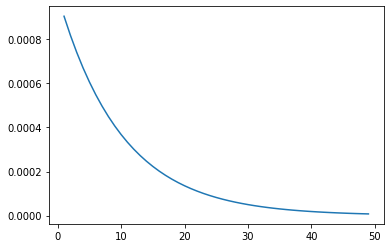

In [8]:
def scheduler(epoch):

  initial_lrate = (10 ** -3)
  k = 0.1
  lrate = initial_lrate * math.exp(-k * (epoch))

  return lrate
epochs = [i for i in range(1, 50, 1)]
lrate = [scheduler(i) for i in range(1, 50, 1)]
plt.plot(epochs, lrate)
lrschedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

In [9]:
# with strategy.scope():
model = resnet_34()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
model.compile(optimizer=optimizer, loss=loss_object, metrics=train_accuracy)

history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                      validation_data=(x_test, y_test),
                      epochs=50, callbacks=[lrschedule, earlystopping])

Epoch 1/50
1563/1563 [==============================] - 159s 97ms/step - loss: 2.1379 - train_accuracy: 0.4099 - val_loss: 1.9169 - val_train_accuracy: 0.4862
Epoch 2/50
1563/1563 [==============================] - 150s 96ms/step - loss: 1.6472 - train_accuracy: 0.5284 - val_loss: 1.4588 - val_train_accuracy: 0.5653
Epoch 3/50
1563/1563 [==============================] - 150s 96ms/step - loss: 1.3379 - train_accuracy: 0.6007 - val_loss: 1.3015 - val_train_accuracy: 0.6161
Epoch 4/50
1563/1563 [==============================] - 151s 97ms/step - loss: 1.1811 - train_accuracy: 0.6417 - val_loss: 1.2531 - val_train_accuracy: 0.6362
Epoch 5/50
1563/1563 [==============================] - 151s 97ms/step - loss: 1.0584 - train_accuracy: 0.6789 - val_loss: 1.0883 - val_train_accuracy: 0.6693
Epoch 6/50
1563/1563 [==============================] - 151s 97ms/step - loss: 0.9876 - train_accuracy: 0.7005 - val_loss: 0.9909 - val_train_accuracy: 0.7067
Epoch 7/50
1563/1563 [========================

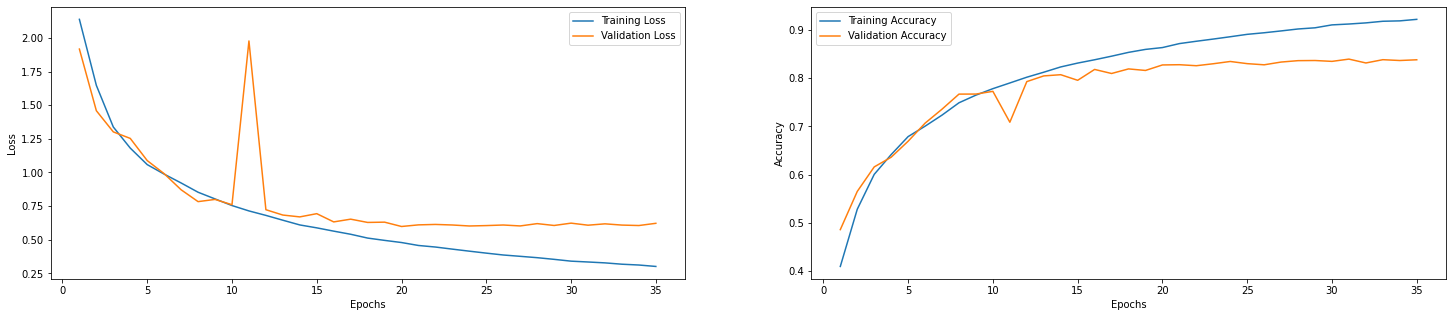

In [16]:
# history_dict = model.history

loss = history.history["loss"]
train_accuracy = history.history["train_accuracy"]
val_loss = history.history["val_loss"]
val_train_accuracy = history.history["val_train_accuracy"]

epochs = range(1, len(loss) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(25)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, train_accuracy, label = "Training Accuracy")
ax2.plot(epochs, val_train_accuracy, label = "Validation Accuracy")
ax2.set(xlabel = "Epochs", ylabel = "Accuracy")
ax2.legend()

plt.show()

In [11]:
model.save("resnet-34")

INFO:tensorflow:Assets written to: resnet-34/assets


INFO:tensorflow:Assets written to: resnet-34/assets


In [15]:
!zip -r /content/resnet-34.zip /content/resnet-34

updating: content/resnet-34/ (stored 0%)
  adding: content/resnet-34/keras_metadata.pb (deflated 95%)
  adding: content/resnet-34/variables/ (stored 0%)
  adding: content/resnet-34/variables/variables.index (deflated 80%)
  adding: content/resnet-34/variables/variables.data-00000-of-00001 (deflated 28%)
  adding: content/resnet-34/saved_model.pb (deflated 91%)
  adding: content/resnet-34/assets/ (stored 0%)
